****
## Feature Selection ###

### 1. Model based feature selection #####

In [1]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**[Allstate Purchase Prediction Challenge](https://www.kaggle.com/c/allstate-purchase-prediction-challenge/data)**
- 고객이 자동차 보험상품을 구매하기까지의 transaction 기록 
- 각 customer ID 별로 quote history 포함
- 각 customer ID 별 마지막 행이 구매 포인트 (record_type=1)

In [2]:
data = pd.read_csv('Allstate_train.csv')
data.head()

customer_ID  shopping_pt  record_type  day   time state  location  \
0     10000000            1            0    0  08:35    IN     10001   
1     10000000            2            0    0  08:38    IN     10001   
2     10000000            3            0    0  08:38    IN     10001   
3     10000000            4            0    0  08:39    IN     10001   
4     10000000            5            0    0  11:55    IN     10001   

   group_size  homeowner  car_age  ...  C_previous  duration_previous  A  B  \
0           2          0        2  ...         1.0                2.0  1  0   
1           2          0        2  ...         1.0                2.0  1  0   
2           2          0        2  ...         1.0                2.0  1  0   
3           2          0        2  ...         1.0                2.0  1  0   
4           2          0        2  ...         1.0                2.0  1  0   

   C  D  E  F  G  cost  
0  2  2  1  2  2   633  
1  2  2  1  2  1   630  
2  2  2  1  2  1   630  
3  2  2  1  2  1   630  
4  2  2  1  2  1   630  

[5 rows x 25 columns]

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)   

In [4]:
from sklearn.feature_selection import SelectFromModel # 중요한 피쳐를 선택

from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(), threshold=None) # threshold=None 스스로 알아서 처리
# select 는 전처리기

In [5]:
X_train_fs = select.fit(X_train, y_train).transform(X_train)
# 변수의 중요도가 나온다.
print("X_train.shape: {}, X_train_fs.shape: {}".format(
    X_train.shape, X_train_fs.shape))

X_train.shape: (426, 30), X_train_fs.shape: (426, 6)


c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


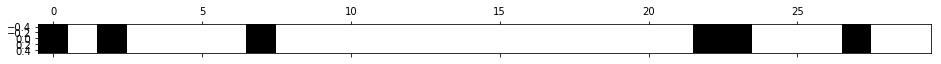

In [6]:
# 선택된 특성을 불리언 값으로 표시해주어 어떤 특성이 선택되었는지 확인 할 수 있다.
mask = select.get_support() 
plt.matshow(mask.reshape(1,-1), cmap="gray_r")
# reshape : 파라미터로 입력한 차원에 맞게 변경한다. -1로 설정하면 나머지를 자동으로 맞춘다.
# 예) (100,) -> (2, 50) : 변환 가능
# 예) (100,) -> (2, -1) : 1차원은 2로 지정하고 2차원은 자동이므로 50이 된다

<font color = "blue">
In **numpy.reshape()**, one shape dimension can be **-1**. In this case, the value is inferred from the length of the array and remaining dimensions.

<font color = "blue">
All built-in colormaps can be reversed by appending **_r**: For instance, **gray_r** is the reverse of **gray**.<br>
See [color map](https://matplotlib.org/2.0.2/api/pyplot_summary.html#matplotlib.pyplot.colormaps).

In [7]:
from sklearn.svm import SVC
svm = SVC(C=100)
svm.fit(X_train, y_train).score(X_test, y_test)

c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6293706293706294

In [8]:
X_test_fs = select.transform(X_test)
svm.fit(X_train_fs, y_train).score(X_test_fs, y_test)

c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6293706293706294

### 2. Univariate feature selection

In [9]:
#단일 변수 선택법은 각각의 독립변수를 하나만 사용한 예측모형의 성능을 이용하여 
#가장 성능이 높은 변수만 선택하는 방법
from sklearn.feature_selection import SelectKBest
# 성능이 높은 변수들을 선택
print(X_train.shape)
X_train_new = SelectKBest(k=5).fit_transform(X_train, y_train) # 5개를 선택해 fit, transform을 동시에 해야함.
X_train_new.shape

(426, 30)


(426, 5)

****
## Feature Generation ###

### Automatic generating polynomial and interaction features
입력값  x 를 다항식으로 변환한다.
$$ x →[1,x,x^2,x^3,⋯] $$

만약 열의 갯수가 두 개이고 2차 다항식으로 변환하는 경우에는 다음처럼 변환한다.
$$ [x_1,x_2]→[1,x_1,x_2,x_1^2,x_1x_2,x_2^2] $$

다음과 같은 파라미터를 가진다.
- degree : 차수
- interaction_only: interaction(상호작용) 항 생성 여부
- include_bias : 상수항 생성 여부

In [10]:
from sklearn.preprocessing import PolynomialFeatures # 다항 변환

X = np.arange(1,7).reshape(3, 2)
X

array([[1, 2],
       [3, 4],
       [5, 6]])

In [11]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  3.,  4.,  9., 12., 16.],
       [ 1.,  5.,  6., 25., 30., 36.]])

In [12]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

array([[ 1.,  1.,  2.,  2.],
       [ 1.,  3.,  4., 12.],
       [ 1.,  5.,  6., 30.]])

In [13]:
print(X_train.shape)

poly = PolynomialFeatures(2)
poly.fit_transform(X_train).shape

(426, 30)


(426, 496)

<font color='blue'>
#### 기타 [Discretization](http://scikit-learn.org/stable/modules/preprocessing.html#discretization)과 [Dimensionality reduction](http://scikit-learn.org/stable/modules/unsupervised_reduction.html) 등도 Feature Engineering에서 자주 사용되는 방법이다.

# ML Workflow Optimization
<font color=#CC3D3D>
## Pipeline: chaining estimators   
</font>
- Pipeline can be used to chain multiple estimators into one.
- Pipeline serves two purposes:
  - Convenience and encapsulation
  - Joint parameter selection
- All estimators in a pipeline, except the last one, must be transformers. 
  - The last estimator may be any type (transformer, classifier, etc.)
- Training and prediction procedure of the pipeline
<br>
<img align="left" src="http://drive.google.com/uc?export=view&id=1pIde-P6d7EnjL3xYo8eE3cWAUEvzV7tS" >

<font color = "#CC3D3D">
### Building Pipelines

In [14]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [15]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

<font color = "blue">
The **Pipeline** is built using a list of **(key, value)** pairs, where the **key** is a string containing the name you want to give this step and **value** is an estimator object:

In [16]:
pipe.fit(X_train, y_train).score(X_test, y_test)

c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.951048951048951

<font color = "blue">
You only have to call **fit** and **predict** once on your data to fit a whole sequence of estimators

<font color = "#CC3D3D">
### Using Pipelines in Grid-searches

In [17]:
from sklearn.model_selection import GridSearchCV # 최적의 파라미터 검색

In [18]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

<font color = "blue">
Parameters of the estimators in the pipeline shoud be defined using the **estimator__parameter** syntax

In [19]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(
    grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


<font color = "#CC3D3D">
### Convenient Pipeline creation with *make_pipeline* ##

In [20]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), 
                      ("svm", SVC(C=100))])
#pipe_long = Pipeline([('pca', PCA(n_components=3))), 
 #                     (('univ_select', SelectKBest(k=10))])
# abbreviated syntax 이름을 넣지 않고 파이프 라인 만들기
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100)) 

In [21]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


<font color = "blue">
**Make_pipeline** does not require, and does not permit, naming the estimators. Instead, their names will be set to the **lowercase of their types** automatically.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), 
                     StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


<font color = "#CC3D3D">
### Combining Features with *FeatureUnion* ##
<img align='left' src='https://image.slidesharecdn.com/featureengineeringpipelines1-161106200348/95/feature-engineering-pipelines-11-638.jpg?cb=1478462927' width=600 height=400>

In [23]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA # 차원축소 
from sklearn.feature_selection import SelectKBest # 성능이 좋은 변수만 사용하는 전처리기

In [24]:
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('univ_select', SelectKBest(k=10)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('features', feature_union))
estimators.append(('scaler', MinMaxScaler()))
estimators.append(("svm", SVC()))
pipe = Pipeline(estimators)

In [25]:
pipe.fit(X_train, y_train).score(X_test, y_test)

c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.958041958041958

In [26]:
# Do grid search
param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[9, 10, 11],
                  svm__C=[0.1, 1, 10],
                  svm__gamma=[0.1, 1, 10])
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)
print(grid_search.fit(X_train, y_train).score(X_test, y_test))
print(grid_search.best_estimator_)

0.965034965034965
Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=10, score_func=<function f_classif at 0x00000275C34BB730>))],
       tra...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<font color = "#CC3D3D">
### Implementing Custom Transformers ##

In [27]:
import pandas as pd
import numpy as np

train = pd.read_csv('titanic_train.csv')
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

#### 타이타닉 호 침몰 당시의 승객 명단 데이터

- Survived: 생존 여부 => 0 = No, 1 = Yes
- pclass: 티켓 등급 => 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex: 성별
- Age: 나이
- Sibsp: 함께 탑승한 형제자매, 배우자의 수
- Parch: 함께 탑승한 부모, 자식의 수
- Ticket: 티켓 번호
- Fare: 운임
- Cabin: 객실 번호
- Embarked: 탑승 항구 => C = Cherbourg, Q = Queenstown, S = Southampton

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [29]:
train.iloc[:,2:]

Pclass                                               Name     Sex   Age  \
0         3                            Braund, Mr. Owen Harris    male  22.0   
1         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2         3                             Heikkinen, Miss. Laina  female  26.0   
3         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4         3                           Allen, Mr. William Henry    male  35.0   
5         3                                   Moran, Mr. James    male   NaN   
6         1                            McCarthy, Mr. Timothy J    male  54.0   
7         3                     Palsson, Master. Gosta Leonard    male   2.0   
8         3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0   
9         2                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0   
10        3                    Sandstrom, Miss. Marguerite Rut  female   4.0   
11        1                           Bonnell, Miss. Elizabeth  female  58.0   
12        3                     Saundercock, Mr. William Henry    male  20.0   
13        3                        Andersson, Mr. Anders Johan    male  39.0   
14        3               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0   
15        2                   Hewlett, Mrs. (Mary D Kingcome)   female  55.0   
16        3                               Rice, Master. Eugene    male   2.0   
17        2                       Williams, Mr. Charles Eugene    male   NaN   
18        3  Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0   
19        3                            Masselmani, Mrs. Fatima  female   NaN   
20        2                               Fynney, Mr. Joseph J    male  35.0   
21        2                              Beesley, Mr. Lawrence    male  34.0   
22        3                        McGowan, Miss. Anna "Annie"  female  15.0   
23        1                       Sloper, Mr. William Thompson    male  28.0   
24        3                      Palsson, Miss. Torborg Danira  female   8.0   
25        3  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0   
26        3                            Emir, Mr. Farred Chehab    male   NaN   
27        1                     Fortune, Mr. Charles Alexander    male  19.0   
28        3                      O'Dwyer, Miss. Ellen "Nellie"  female   NaN   
29        3                                Todoroff, Mr. Lalio    male   NaN   
..      ...                                                ...     ...   ...   
861       2                        Giles, Mr. Frederick Edward    male  21.0   
862       1  Swift, Mrs. Frederick Joel (Margaret Welles Ba...  female  48.0   
863       3                  Sage, Miss. Dorothy Edith "Dolly"  female   NaN   
864       2                             Gill, Mr. John William    male  24.0   
865       2                           Bystrom, Mrs. (Karolina)  female  42.0   
866       2                       Duran y More, Miss. Asuncion  female  27.0   
867       1               Roebling, Mr. Washington Augustus II    male  31.0   
868       3                        van Melkebeke, Mr. Philemon    male   NaN   
869       3                    Johnson, Master. Harold Theodor    male   4.0   
870       3                                  Balkic, Mr. Cerin    male  26.0   
871       1   Beckwith, Mrs. Richard Leonard (Sallie Monypeny)  female  47.0   
872       1                           Carlsson, Mr. Frans Olof    male  33.0   
873       3                        Vander Cruyssen, Mr. Victor    male  47.0   
874       2              Abelson, Mrs. Samuel (Hannah Wizosky)  female  28.0   
875       3                   Najib, Miss. Adele Kiamie "Jane"  female  15.0   
876       3                      Gustafsson, Mr. Alfred Ossian    male  20.0   
877       3                               Petroff, Mr. Nedelio    male  19.0   
878       3                                 Laleff, Mr. Kristo    male   NaN   
879  

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,2:], train.Survived, random_state=0)

#### 전처리 방향
feature를 `수치형과 범주형으로 나누어`<sup>1)</sup> 다르게 전처리를 수행한다.
- 수치형의 경우: 결측값을 중앙값으로 대체 -> Standardization
- 범주형의 경우: `결측값이 없는 모든 범주형 feature에 대해 One-Hot-Encoding 수행`<sup>2)</sup>


*<sup>1),2)</sup> scikit-learn에 없는 전처리 기능이기 때문에 Custom Transformer를 만들어야 함.*

In [32]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

# 1)번 Custom Transformer
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names].values

In [34]:
# 2)번 Custom Transformer
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X_cat, y=None):
        return self
    def transform(self, X_cat):
        X_cat_df = pd.DataFrame(X_cat, columns=range(X_cat.shape[1]))
        X_onehot_df = pd.get_dummies(X_cat_df, columns=X_cat_df.columns)
        return X_onehot_df.values

In [27]:
# feature를 수치형과 범주형으로 구분
con = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat = ['Sex', 'Ticket']
#con_idx = [train.columns.get_loc(c) for c in train.columns if c in con]
#cat_idx = [train.columns.get_loc(c) for c in train.columns if c in cat]

In [28]:
# 수치형 feature에 대한 전처리
con_pipeline = Pipeline([
    ('selector', DataFrameSelector(con)),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# 범주형 feature에 대한 전처리
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat)),
    ('encoder', CustomLabelBinarizer()),
])

# 전처리된 수치형과 범주형 feature를 결합
full_pipeline = FeatureUnion([
    ('con_pipeline', con_pipeline),
    ('cat_pipeline', cat_pipeline),
])

c:\users\kduar_000\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)